In [1]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras

plt.rcParams['font.family'] = ['Arial', 'MS Gothic']
plt.rcParams.update({
    'axes.labelsize': 24,     # 軸ラベルのサイズ
    'xtick.labelsize': 18,    # x軸目盛りのサイズ
    'ytick.labelsize': 18,    # y軸目盛りのサイズ
    'axes.titlesize': 24      # タイトルのサイズ
})

In [4]:
import pickle

input_name = 'hippocampus' #'gray-matter' 'hippocampus'
output_name = '灰白質萎縮度' #'MMSE' '灰白質萎縮度'

with open(f"../data/pickle_data/dataset_{input_name}_{output_name}.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37, 64, 32, 32, 1) (10, 64, 32, 32, 1) (37,) (10,)


In [5]:
np.mean(y_train), np.mean(y_test)

(6.4421621621621625, 6.843999999999999)

In [6]:
model = keras.models.Sequential([
    keras.layers.InputLayer(X_train.shape[1:]),

    keras.layers.Conv3D(32, (5, 5, 5), padding="same", activation="relu"),
    keras.layers.Conv3D(32, (5, 5, 5), padding="same", activation="relu"),
    keras.layers.MaxPooling3D((2, 2, 2), padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu"),
    keras.layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu"),
    keras.layers.MaxPooling3D((2, 2, 2), padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv3D(128, (3, 3, 3), padding="same", activation="relu"),
    keras.layers.Conv3D(128, (3, 3, 3), padding="same", activation="relu"),
    keras.layers.MaxPooling3D((2, 2, 2), padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv3D(256, (3, 3, 3), padding="same", activation="relu"),
    keras.layers.Conv3D(256, (3, 3, 3), padding="same", activation="relu"),
    keras.layers.MaxPooling3D((2, 2, 2), padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv3D(512, (1, 1, 1), padding="same", activation="relu"),
    keras.layers.GlobalAveragePooling3D(),
    
    keras.layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.HeNormal()),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(60, activation="linear", kernel_initializer=keras.initializers.HeNormal()),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(20, activation="linear", kernel_initializer=keras.initializers.HeNormal()),
    keras.layers.Dense(1, activation="linear")
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 64, 32, 32, 32)    4032      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 32, 32, 32)    128032    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 16, 16, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 16, 16, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 16, 16, 64)    55360     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 16, 16, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 8, 8, 64)      0

In [8]:
class CustomReduceLROnPlateau(keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_weights = None
        self.best = np.Inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # 損失が改善された場合
        if current < self.best:
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()  # 最良の重みを保存
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # 学習率を下げる
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                if old_lr > self.min_lr:
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                    print(f"\nEpoch {epoch+1}: ReduceLROnPlateau reducing learning rate to {new_lr}.")
                    
                    # 最良の重みを復元
                    if self.best_weights is not None:
                        self.model.set_weights(self.best_weights)
                self.wait = 0

In [9]:
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
custom_reduce_lr = CustomReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

model.compile(loss="mse",
              metrics=["mse"],
              optimizer=keras.optimizers.SGD(learning_rate=0.001))

history = model.fit(
    X_train, y_train,
    validation_data=(X_train, y_train),
    epochs=50,
    batch_size=8,
    verbose=2
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_train, y_train),
    epochs=50,
    batch_size=8,
    callbacks=[custom_reduce_lr, early_stopping],
    verbose=2
)


Epoch 1/50
5/5 - 6s - loss: 34.8247 - mse: 34.8247 - val_loss: 45.5963 - val_mse: 45.5963
Epoch 2/50
5/5 - 0s - loss: 19.2393 - mse: 19.2393 - val_loss: 46.5306 - val_mse: 46.5306
Epoch 3/50
5/5 - 0s - loss: 15.2613 - mse: 15.2613 - val_loss: 45.5860 - val_mse: 45.5860
Epoch 4/50
5/5 - 0s - loss: 17.5601 - mse: 17.5601 - val_loss: 44.8135 - val_mse: 44.8135
Epoch 5/50
5/5 - 0s - loss: 20.0291 - mse: 20.0291 - val_loss: 38.0491 - val_mse: 38.0491
Epoch 6/50
5/5 - 0s - loss: 16.9439 - mse: 16.9439 - val_loss: 34.7623 - val_mse: 34.7623
Epoch 7/50
5/5 - 0s - loss: 19.4778 - mse: 19.4778 - val_loss: 26.8874 - val_mse: 26.8874
Epoch 8/50
5/5 - 0s - loss: 16.1316 - mse: 16.1316 - val_loss: 22.3600 - val_mse: 22.3600
Epoch 9/50
5/5 - 0s - loss: 12.6795 - mse: 12.6795 - val_loss: 15.1148 - val_mse: 15.1148
Epoch 10/50
5/5 - 0s - loss: 15.2082 - mse: 15.2082 - val_loss: 19.1306 - val_mse: 19.1306
Epoch 11/50
5/5 - 0s - loss: 9.7340 - mse: 9.7340 - val_loss: 16.3094 - val_mse: 16.3094
Epoch 12/5

In [10]:
def r2(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - mean_y) ** 2)

    r2 = 1 - (ss_res / ss_tot)
    return r2

RMSE:  4.737542671865104
PCC:   0.5254471723584436
R2:    -0.8996852758590763


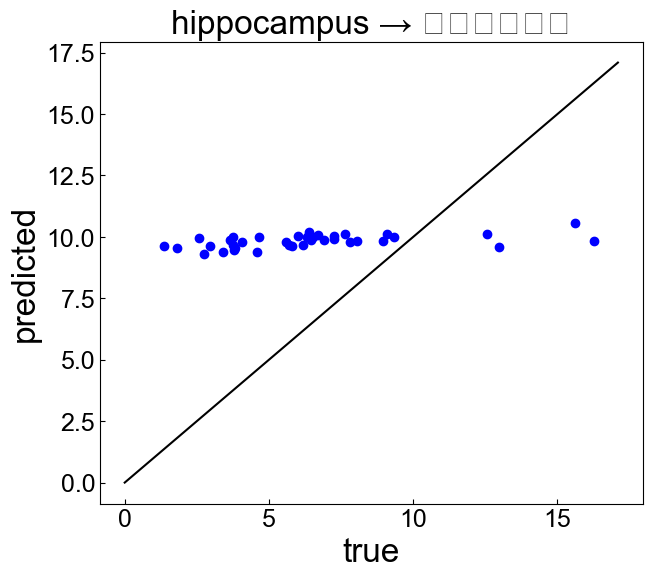

In [13]:
y_pred = model.predict(X_train)
y_pred = y_pred.reshape(y_pred.shape[0], )
y_true = y_train

RMSE = np.sqrt(np.mean((y_pred - y_true) ** 2))
PCC = np.corrcoef(y_true, y_pred)[0][1]
R2 = r2(y_true, y_pred)

print("RMSE: ", RMSE)
print("PCC:  ", PCC)
print("R2:   ", R2)

fig = plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, c="blue")
plt.plot([0,max(y_true)*1.05], [0,max(y_true)*1.05], c="black")
plt.tick_params(direction="in")
plt.xlabel("true")
plt.ylabel("predicted")
plt.title(f"{input_name} → {output_name}")
plt.savefig(f"../output/graph_CNN/{input_name}_{output_name}_train.png")
plt.show()

RMSE:  4.502079878872351
PCC:   0.8471370808613691
R2:    -0.5837607674970313


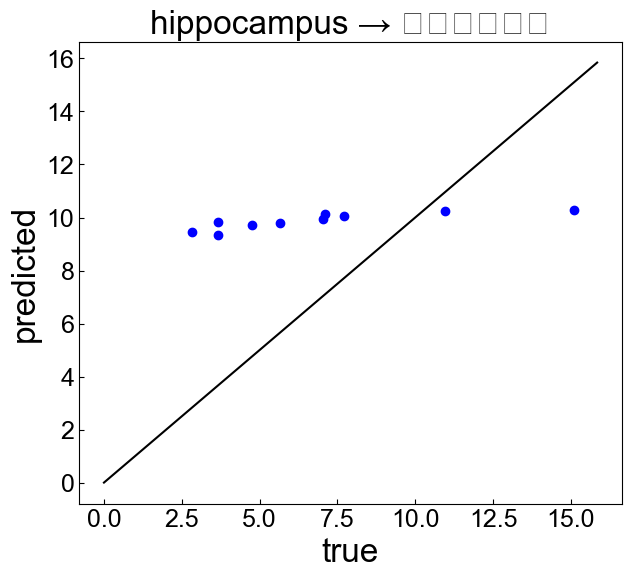

In [14]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], )
y_true = y_test

RMSE = np.sqrt(np.mean((y_pred - y_true) ** 2))
PCC = np.corrcoef(y_true, y_pred)[0][1]
R2 = r2(y_true, y_pred)

print("RMSE: ", RMSE)
print("PCC:  ", PCC)
print("R2:   ", R2)

fig = plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, c="blue")
plt.plot([0,max(y_true)*1.05], [0,max(y_true)*1.05], c="black")
plt.tick_params(direction="in")
plt.xlabel("true")
plt.ylabel("predicted")
plt.title(f"{input_name} → {output_name}")
plt.savefig(f"../output/graph_CNN/{input_name}_{output_name}_test.png")
plt.show()